<a href="https://colab.research.google.com/github/santoshgurujula/Springboard/blob/master/TimeSeriesModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First, import the relevant modules
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
plt.rcParams['figure.figsize'] = 10,6

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import tensorflow as tf 
tf.test.gpu_device_name() 

''

In [3]:
#pointing the path to google drive folder
%cd '/content/drive/My Drive/Springboard/data'
!ls

/content/drive/My Drive/Springboard/data
BOM500002.csv  BOM500013.csv  fig2.png
BOM500003.csv  BOM500014.csv  FinalStockData.csv
BOM500008.csv  BOM500020.csv  interpolating-timeseries-p1-pandas-fig1.png
BOM500009.csv  BOM500023.csv  nasdl.csv
BOM500010.csv  DJI.csv
BOM500012.csv  fig1.png


In [4]:
dataset = pd.read_csv('/content/drive/My Drive/Springboard/data/FinalStockData.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Columns: 133 entries, Unnamed: 0 to Volume
dtypes: float64(131), int64(1), object(1)
memory usage: 768.0+ KB


In [5]:
dataset.head()

,Unnamed: 0,Date,Open_BOM500002,Open_BOM500003,Open_BOM500008,Open_BOM500009,Open_BOM500010,Open_BOM500012,Open_BOM500013,Open_BOM500014,Open_BOM500020,Open_BOM500023,High_BOM500002,High_BOM500003,High_BOM500008,High_BOM500009,High_BOM500010,High_BOM500012,High_BOM500013,High_BOM500014,High_BOM500020,High_BOM500023,Low_BOM500002,Low_BOM500003,Low_BOM500008,Low_BOM500009,Low_BOM500010,Low_BOM500012,Low_BOM500013,Low_BOM500014,Low_BOM500020,Low_BOM500023,Close_BOM500002,Close_BOM500003,Close_BOM500008,Close_BOM500009,Close_BOM500010,Close_BOM500012,Close_BOM500013,Close_BOM500014,...,% Deli. Qty to Traded Qty_BOM500003,% Deli. Qty to Traded Qty_BOM500008,% Deli. Qty to Traded Qty_BOM500009,% Deli. Qty to Traded Qty_BOM500010,% Deli. Qty to Traded Qty_BOM500012,% Deli. Qty to Traded Qty_BOM500013,% Deli. Qty to Traded Qty_BOM500014,% Deli. Qty to Traded Qty_BOM500020,% Deli. Qty to Traded Qty_BOM500023,Spread H-L_BOM500002,Spread H-L_BOM500003,Spread H-L_BOM500008,Spread H-L_BOM500009,Spread H-L_BOM500010,Spread H-L_BOM500012,Spread H-L_BOM500013,Spread H-L_BOM500014,Spread H-L_BOM500020,Spread H-L_BOM500023,Spread C-O_BOM500002,Spread C-O_BOM500003,Spread C-O_BOM500008,Spread C-O_BOM500009,Spread C-O_BOM500010,Spread C-O_BOM500012,Spread C-O_BOM500013,Spread C-O_BOM500014,Spread C-O_BOM500020,Spread C-O_BOM500023,Gross_Purchases,Gross_Sales,Net_Investment_INR,Net_Investment_USD,Conversion_Rate,Open,High,Low,Close,Adj Close,Volume
0,0,2017-01-02,1045.0,129.00,870.05,7.00,1275.00,21.9,15.50,2.50,49.05,NaN,1052.0,132.45,898.95,7.89,1275.0,22.00,16.08,2.50,49.90,NaN,1035.00,129.00,867.6,7.00,1214.15,21.50,14.86,2.30,48.35,NaN,1039.95,131.05,896.20,7.09,1219.25,21.60,15.30,2.37,...,59.65,12.15,87.01,21.24,77.39,38.58,82.68,27.28,NaN,17.00,3.45,31.35,0.89,60.85,0.50,1.22,0.20,1.55,NaN,-5.05,2.05,26.15,0.09,-55.75,-0.30,-0.20,-0.13,-0.25,NaN,2230.64,2796.67,-566.03,-83.29,67.9547,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2017-01-03,1069.9,132.30,900.00,7.04,1220.00,21.9,15.50,2.47,49.00,106.950000,1069.9,135.00,900.00,7.30,1222.0,21.90,15.70,2.48,49.80,106.950000,1037.90,132.00,882.9,7.04,1201.00,21.10,15.10,2.32,48.55,106.950000,1045.05,132.50,890.20,7.25,1215.25,21.70,15.32,2.43,...,37.15,24.99,89.13,54.61,89.96,64.98,80.71,44.10,100.000000,32.00,3.00,17.10,0.26,21.00,0.80,0.60,0.16,1.25,0.000000,-24.85,0.20,-9.80,0.21,-4.75,-0.20,-0.18,-0.04,-0.20,0.000000,867.26,1185.97,-318.71,-46.85,68.0225,19872.859375,19938.529297,19775.929688,19881.759766,19881.759766,339180000.0
2,2,2017-01-04,1050.0,134.15,892.00,7.13,1215.25,22.5,15.32,2.48,50.25,104.050000,1050.0,134.60,909.25,7.40,1225.0,22.75,15.44,2.50,51.90,104.050000,1033.50,131.25,890.0,7.11,1197.55,21.25,15.12,2.35,50.25,104.025000,1037.35,131.75,898.50,7.26,1212.50,22.75,15.28,2.47,...,61.49,24.11,83.89,92.28,74.31,84.28,96.69,31.95,100.000000,16.50,3.35,19.25,0.29,27.45,1.50,0.32,0.15,1.65,0.025000,-12.65,-2.40,6.50,0.13,-2.75,0.25,-0.04,-0.01,0.65,-0.025000,1863.97,2400.72,-536.75,-78.84,68.0864,19890.939453,19956.140625,19878.830078,19942.160156,19942.160156,280010000.0
3,3,2017-01-05,1051.9,132.00,905.00,7.02,1225.00,23.7,15.43,2.34,51.25,101.150000,1051.9,133.25,935.25,7.50,1225.0,23.85,15.52,2.49,54.40,101.150000,1029.55,130.00,900.0,7.02,1205.30,22.90,15.26,2.33,51.20,101.100000,1031.45,131.65,916.35,7.34,1216.55,23.85,15.48,2.41,...,59.06,27.79,72.79,23.37,73.78,76.37,69.64,32.58,100.000000,22.35,3.25,35.25,0.48,19.70,0.95,0.26,0.16,3.20,0.050000,-20.45,-0.35,11.35,0.32,-8.45,0.15,0.05,0.07,2.60,-0.050000,3534.18,4226.17,-691.99,-101.50,68.1791,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000.0
4,4,2017-01-06,1037.0,132.90,916.35,7.35,1216.55,24.9,15.26,2.36,54.20,101.166667,1048.0,133.00,932.15,7.55,1232.4,25.00,15.45,2.45,54.35,101.766667,1035.55,129.55,915.0,7.21,1216.55,23.00,15.01,2.35,52.75,101.133333,1043.90,130.10,928.05,7.40,1222.15,24.95,15.11,2.45,...,49.28,12.28,85.11,82.03,70.79,73.11,87.23,38.97,83.333333,12.45,3.45,17.15,0.34,15.85,2.00,0.44,0.10,

In [6]:
print(dataset.columns)

Index(['Unnamed: 0', 'Date', 'Open_BOM500002', 'Open_BOM500003',
       'Open_BOM500008', 'Open_BOM500009', 'Open_BOM500010', 'Open_BOM500012',
       'Open_BOM500013', 'Open_BOM500014',
       ...
       'Gross_Sales', 'Net_Investment_INR', 'Net_Investment_USD',
       'Conversion_Rate', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume'],
      dtype='object', length=133)


In [7]:
#select only 1 stock Open and close, Conversion_rate , Dowjones Open and close columns
features= ['Date','Open_BOM500002','Close_BOM500002', 'Conversion_Rate','Open','Close']
sub_dataset=dataset[features]

In [8]:
sub_dataset.head()

,Date,Open_BOM500002,Close_BOM500002,Conversion_Rate,Open,Close
0,2017-01-02,1045.0,1039.95,67.9547,NaN,NaN
1,2017-01-03,1069.9,1045.05,68.0225,19872.859375,19881.759766
2,2017-01-04,1050.0,1037.35,68.0864,19890.939453,19942.160156
3,2017-01-05,1051.9,1031.45,68.1791,19924.560547,19899.289063
4,2017-01-06,1037.0,1043.90,67.7884,19906.960938,19963.800781


In [9]:
sub_dataset.sort_values(by='Date')

,Date,Open_BOM500002,Close_BOM500002,Conversion_Rate,Open,Close
0,2017-01-02,1045.0,1039.95,67.9547,NaN,NaN
1,2017-01-03,1069.9,1045.05,68.0225,19872.859375,19881.759766
2,2017-01-04,1050.0,1037.35,68.0864,19890.939453,19942.160156
3,2017-01-05,1051.9,1031.45,68.1791,19924.560547,19899.289063
4,2017-01-06,1037.0,1043.90,67.7884,19906.960938,19963.800781
...,...,...,...,...,...,...
734,2019-12-24,1278.5,1255.15,71.1699,28572.570313,28515.449219
735,2019-12-26,1265.0,1268.50,71.1959,28539.460938,28621.390625
736,2019-12-27,1280.0,1275.75,71.2699,28675.339844,28645.259766
737,2019-12-30,1277.0,1287.35,71.2214,28654.759766,28462.140625


In [10]:
#parse string to datetime
sub_dataset['Date']=pd.to_datetime(sub_dataset['Date'],infer_datetime_format=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
IndexedDataset=sub_dataset.set_index(['Date'])

In [12]:
IndexedDataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 739 entries, 2017-01-02 to 2019-12-31
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open_BOM500002   739 non-null    float64
 1   Close_BOM500002  739 non-null    float64
 2   Conversion_Rate  739 non-null    float64
 3   Open             738 non-null    float64
 4   Close            738 non-null    float64
dtypes: float64(5)
memory usage: 34.6 KB


In [13]:
IndexedDataset.head()

,Open_BOM500002,Close_BOM500002,Conversion_Rate,Open,Close
Date,,,,,
2017-01-02,1045.0,1039.95,67.9547,NaN,NaN
2017-01-03,1069.9,1045.05,68.0225,19872.859375,19881.759766
2017-01-04,1050.0,1037.35,68.0864,19890.939453,19942.160156
2017-01-05,1051.9,1031.45,68.1791,19924.560547,19899.289063
2017-01-06,1037.0,1043.90,67.7884,19906.960938,19963.800781


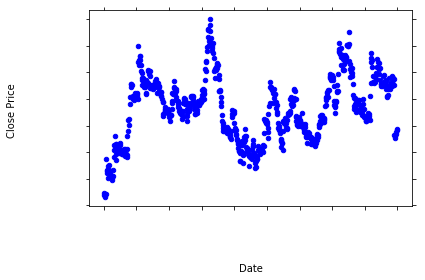

In [14]:
#plot Graph
#Plot stock Close price  against Date 
plt.scatter(IndexedDataset.index,
               IndexedDataset['Close_BOM500002'],
               color='blue',
               s=20)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)

plt.xlabel('Date', labelpad=40)
plt.ylabel('Close Price ', labelpad=40)

plt.tight_layout()
plt.savefig('fig1.png')
plt.show()
plt.close()

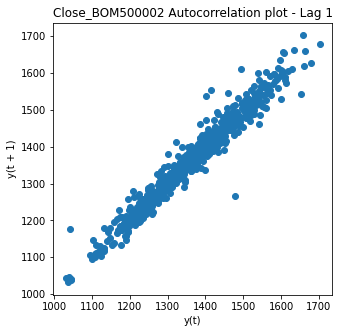

In [15]:
#plot the Autocorrelation plot for feature 'Close'
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(IndexedDataset['Close_BOM500002'], lag=1)
plt.title('Close_BOM500002 Autocorrelation plot - Lag 1');
# END_CODE_HERE

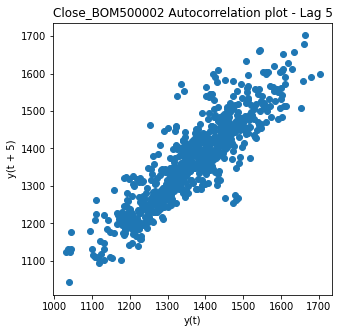

In [16]:
#  plot the Autocorrelation plot for feature 'Close' with Lag5

plt.figure(figsize=(5,5))
lag_plot(IndexedDataset['Close_BOM500002'], lag=5)
plt.title('Close_BOM500002 Autocorrelation plot - Lag 5');


Build Train and Test Data set

In [17]:
train_data, test_data = IndexedDataset.iloc[0:int(len(IndexedDataset)*0.8), :], IndexedDataset.iloc[int(len(IndexedDataset)*0.8):, :]

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 591 entries, 2017-01-02 to 2019-05-23
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open_BOM500002   591 non-null    float64
 1   Close_BOM500002  591 non-null    float64
 2   Conversion_Rate  591 non-null    float64
 3   Open             590 non-null    float64
 4   Close            590 non-null    float64
dtypes: float64(5)
memory usage: 27.7 KB


In [19]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148 entries, 2019-05-24 to 2019-12-31
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open_BOM500002   148 non-null    float64
 1   Close_BOM500002  148 non-null    float64
 2   Conversion_Rate  148 non-null    float64
 3   Open             148 non-null    float64
 4   Close            148 non-null    float64
dtypes: float64(5)
memory usage: 6.9 KB


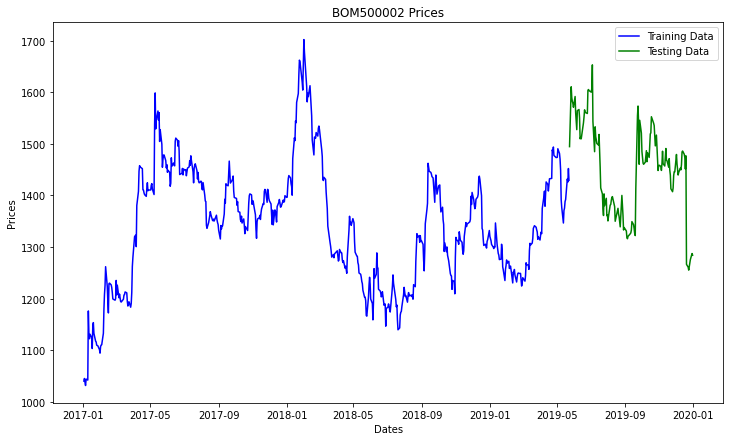

In [20]:
plt.figure(figsize=(12,7))
plt.title('BOM500002 Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Close_BOM500002'], 'blue', label='Training Data')
plt.plot(test_data['Close_BOM500002'], 'green', label='Testing Data')
plt.legend();

In [21]:
#Check Rolling mean and std
rolmean = train_data.rolling(window=5).mean()
rolstd =  train_data.rolling(window=5).std()

print(rolmean,rolstd)

            Open_BOM500002  Close_BOM500002  ...          Open         Close
Date                                         ...                            
2017-01-02             NaN              NaN  ...           NaN           NaN
2017-01-03             NaN              NaN  ...           NaN           NaN
2017-01-04             NaN              NaN  ...           NaN           NaN
2017-01-05             NaN              NaN  ...           NaN           NaN
2017-01-06         1050.76          1039.54  ...           NaN           NaN
...                    ...              ...  ...           ...           ...
2019-05-17         1372.09          1374.62  ...  25552.862109  25626.348047
2019-05-20         1375.90          1391.69  ...  25570.312109  25697.330078
2019-05-21         1395.58          1402.72  ...  25649.974219  25766.385938
2019-05-22         1406.54          1418.08  ...  25733.640235  25792.103906
2019-05-23         1423.10          1426.30  ...  25726.810156  25717.662109

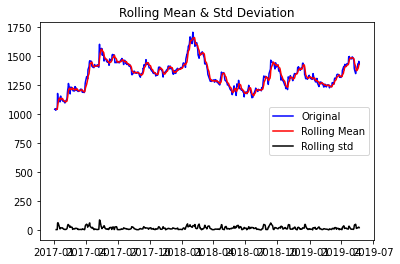

In [22]:
orig = plt.plot(train_data['Close_BOM500002'],color='blue',label='Original')
mean= plt.plot(rolmean['Close_BOM500002'],color='red',label='Rolling Mean')
std= plt.plot(rolstd['Close_BOM500002'],color='black',label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean & Std Deviation')
plt.show(block=False)

In [23]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

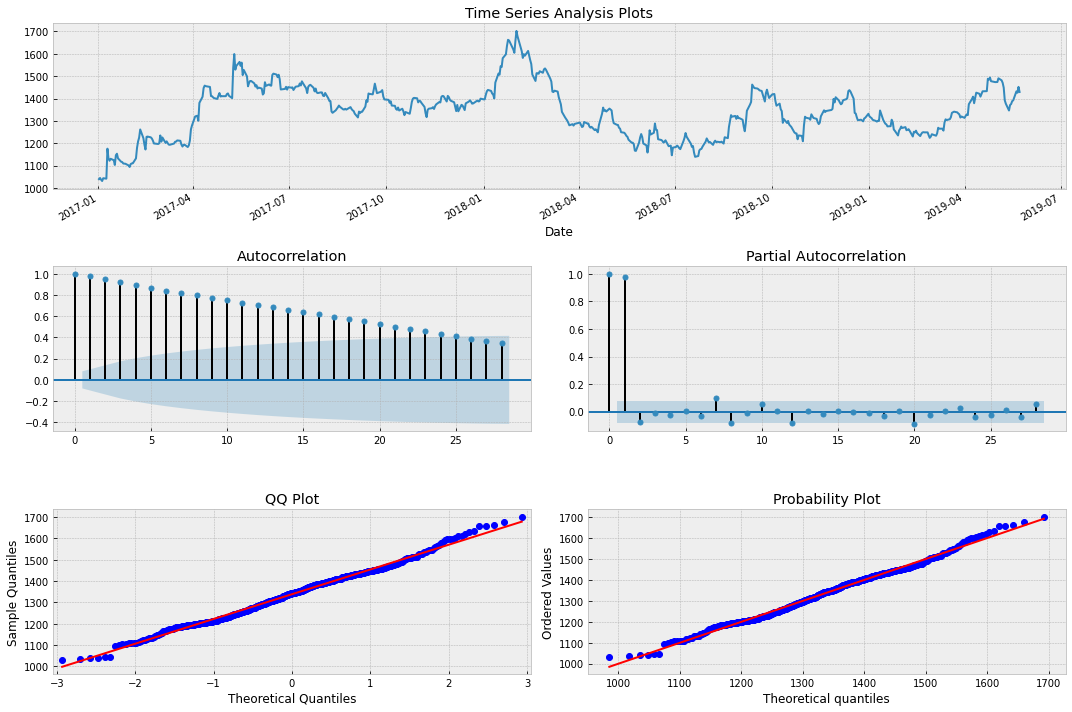

In [24]:
tsplot(train_data['Close_BOM500002'])

**We observe there is trend above ACF plot**

Below  we remove trend by using np.diff()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


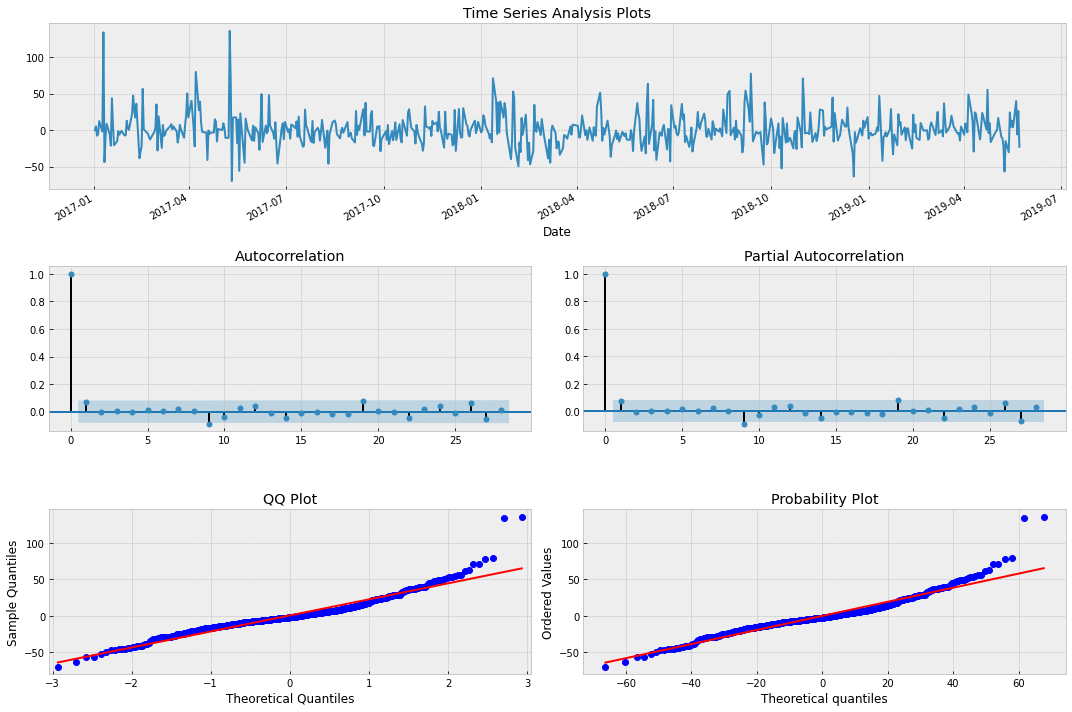

In [25]:
#use np.diff to remove trend
#train_data['Close_BOM500002_log']=np.log(train_data['Close_BOM500002'])
train_data['Close_BOM500002_diff']=np.append(0,np.diff(train_data['Close_BOM500002']))
#IndexedDataset['Close_BOM500002_logdiff']= IndexedDataset['Close_BOM500002']-IndexedDataset['Close_BOM500002'].shift() 
#IndexedDataset['Close_BOM500002_logdiff']
tsplot(train_data['Close_BOM500002_diff'])

**We observe from above plot trend is removed , but we observe correlaion at lag 9,14 .. from ACF and PACF**



In [26]:
#Check Dickey - Fuller test
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey Fuller test:')
dftest=adfuller(train_data['Close_BOM500002'],autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index = ['Test Statistcs ', 'p-value', '#lags used', 'No of Observations used'] )
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key]=value

print(dfoutput)

Results of Dickey Fuller test:
Test Statistcs              -3.106157
p-value                      0.026101
#lags used                   1.000000
No of Observations used    589.000000
Critical Value (1%)         -3.441501
Critical Value (5%)         -2.866460
Critical Value (10%)        -2.569390
dtype: float64


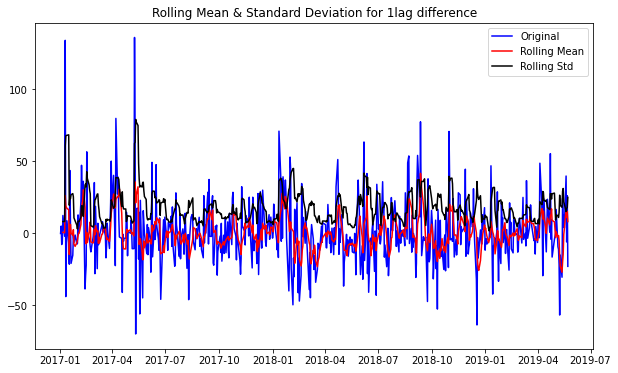

In [27]:
#Determing rolling statistics
window=5
rolmean_diff = train_data['Close_BOM500002_diff'].rolling(window).mean()
rolstd_diff = train_data['Close_BOM500002_diff'].rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_data['Close_BOM500002_diff'], color='blue',label='Original')
mean = plt.plot(rolmean_diff, color='red', label='Rolling Mean')
std = plt.plot(rolstd_diff, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation for 1lag difference');

In [28]:
#Check Dickey - Fuller test
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey Fuller test:')
dftest=adfuller(train_data['Close_BOM500002_diff'],autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index = ['Test Statistcs ', 'p-value', '#lags used', 'No of Observations used'] )
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key]=value

print(dfoutput)

Results of Dickey Fuller test:
Test Statistcs             -22.512213
p-value                      0.000000
#lags used                   0.000000
No of Observations used    590.000000
Critical Value (1%)         -3.441482
Critical Value (5%)         -2.866451
Critical Value (10%)        -2.569386
dtype: float64


After differencing, the p-value is extremely small. Thus this series is very likely to be stationary.



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Partial Autocorrelation Function')

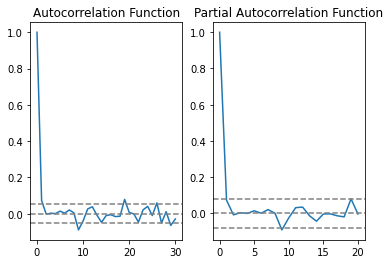

In [29]:
#plot ACF and PACF
from statsmodels.tsa.stattools import acf,pacf

lag_acf=acf(train_data['Close_BOM500002_diff'],nlags=30)
lag_pacf = pacf (train_data['Close_BOM500002_diff'],nlags=20, method ='ols')

#plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.25/np.sqrt(len(train_data['Close_BOM500002_diff'])),linestyle='--',color='gray')
plt.axhline(y=1.25/np.sqrt(len(train_data['Close_BOM500002_diff'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_data['Close_BOM500002_diff'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_data['Close_BOM500002_diff'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')


In [30]:
#creae test difference series and train difference series 
test_series = test_data['Close_BOM500002']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)

train_series = train_data['Close_BOM500002']
train_diff = train_series.diff()
train_diff = test_diff.dropna(inplace = False)

**From ACF, we can say p=1 and from PACF we can say q=1**

Now build ARIMA model using p=1,d=1 and q=1

In [31]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error



In [32]:
%%time 

history = [x for x in train_diff]
p=1
d=1
q=1
predictions = list()
for t in range(len(test_diff)):

    # START_CODE_HERE - call the ARIMA Method with history and params
    
    model = ARIMA(history,order=(p,d,q))  # initialize the model with history and right order of parameters
    model_fit = model.fit(disp=-1)  # fit the model
    # END_CODE_HERE

    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=-4.099322590141112, Expected=116.04999999999995


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test Series Point: 100	Predicted=0.12342321518482802, Expected=-20.699999999999818
CPU times: user 14.3 s, sys: 4.32 ms, total: 14.3 s
Wall time: 14.3 s


In [33]:
#reverse the foreasted values
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((148,), (148,))

In [34]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)

Testing Mean Squared Error: 26484.420


In [35]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [36]:
res_tup = _get_best_model(train_diff)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

aic: 1452.16373 | order: (0, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [37]:
#print best model order
order=res_tup[1]
print(order)

(0, 1, 1)


In [38]:
def build_model(ts_train,ts_test,order):

  %%time 

  history = [x for x in ts_train]

  predictions = list()
  for t in range(len(ts_test)):

      # START_CODE_HERE - call the ARIMA Method with history and params
      
      model = ARIMA(history,order=order)  # initialize the model with history and right order of parameters
      model_fit = model.fit(disp=-1)  # fit the model
      # END_CODE_HERE

      output = model_fit.forecast()  # use forecast on the fitted model
      yhat = output[0][0]
      predictions.append(yhat)

      obs = ts_test[t]
      history.append(obs)

      if t % 100 == 0:
        print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))
  return predictions,model_fit

In [39]:
predictions,model_fit= build_model(train_diff,test_diff,order)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 6.91 µs
Test Series Point: 0	Predicted=-4.0971684485059665, Expected=116.04999999999995
Test Series Point: 100	Predicted=0.2452878992994849, Expected=-20.699999999999818


In [40]:
#reverse the foreasted values
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((148,), (148,))

In [41]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)

Testing Mean Squared Error: 27399.587


Visualize the forecast results


In [42]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_test_diff)
reverse_predictions_series.index = test_series.index

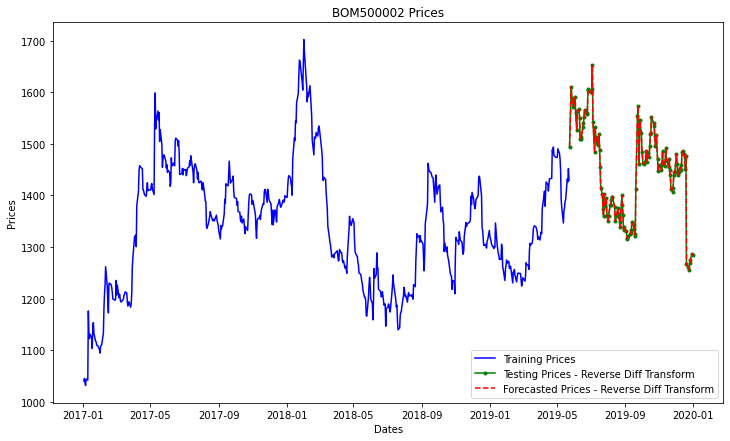

In [43]:
plt.figure(figsize=(12,7))
plt.title('BOM500002 Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

Visualize only test and forecast prices


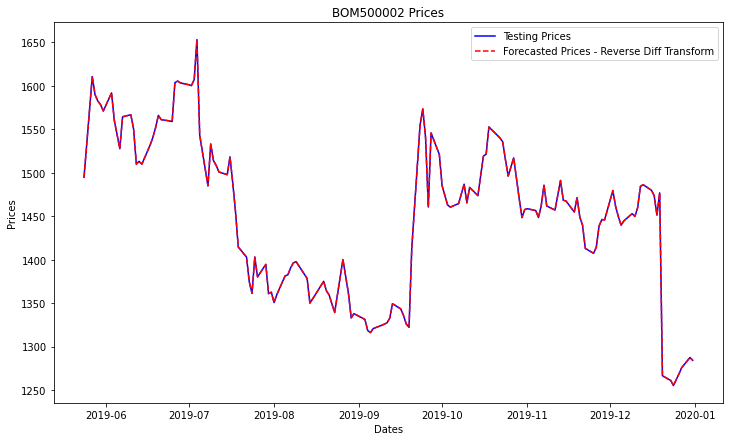

In [44]:
plt.figure(figsize=(12,7))
plt.title('BOM500002 Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(test_series, color='blue', label='Testing Prices')
#plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

In [49]:
# Load in the r magic
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [45]:
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro 
import numpy as np

from rpy2.robjects.packages import importr


from rpy2.robjects.conversion import localconverter
install_code="""install.packages('rmgarch', repos='https://cran.r-project.org/')"""
r_install_code = ro.r(install_code)



/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')
R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘FNN’, ‘kernlab’, ‘mclust’, ‘multicool’, ‘DistributionUtils’, ‘GeneralizedHyperbolic’, ‘gmp’, ‘nloptr’, ‘ks’, ‘numDeriv’, ‘chron’, ‘SkewHyperbolic’, ‘expm’, ‘truncnorm’, ‘Rmpfr’, ‘bit’, ‘mvtnorm’, ‘rugarch’, ‘Rsolnp’, ‘zoo’, ‘xts’, ‘Bessel’, ‘ff’, ‘shape’, ‘pcaPP’, ‘spd’, ‘corpcor’, ‘RcppArmadillo’


R[write to console]: trying URL 'https://cran.r-project.org/src/contrib/FNN_1.1.3.tar.gz'

R[write to

In [50]:
# Initialize R GARCH model
import rpy2.robjects as ro

package_name = "rmgarch"
ro.r(f'install.packages("gmp")')

try:
    pkg = importr(package_name)
except:
    ro.r(f'install.packages("{package_name}")')
    pkg = importr(package_name)
pkg

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/gmp_0.6-0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 156314 bytes (152 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to

RRuntimeError: ignored

In [46]:


# pd_rets - a pandas dataframe of daily returns, where the column names are the tickers of stocks and index is the trading days.

# compute DCC-Garch in R using rmgarch package
pandas2ri.activate()
with localconverter(ro.default_converter + pandas2ri.converter):
  r_rets = ro.conversion.py2rpy(train_data)
#r_rets = pandas2ri.py2ri(pd_rets) # convert the daily returns from pandas dataframe in Python to dataframe in R
r_dccgarch_code = """
                library('rmgarch')
                function(r_rets, n_days){
                        univariate_spec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                                                    variance.model = list(garchOrder = c(1,1),
                                                                        variance.targeting = FALSE, 
                                                                        model = "sGARCH"),
                                                    distribution.model = "norm")
                        n <- dim(r_rets)[2]
                        dcc_spec <- dccspec(uspec = multispec(replicate(n, univariate_spec)),
                                            dccOrder = c(1,1),
                                            distribution = "mvnorm")
                        dcc_fit <- dccfit(dcc_spec, data=r_rets)
                        forecasts <- dccforecast(dcc_fit, n.ahead = n_days)
                        list(dcc_fit, forecasts@mforecast$H)
                }
                """
r_dccgarch = ro.r(r_dccgarch_code)
r_res = r_dccgarch(r_rets,n_days)
pandas2ri.deactivate()
# end of R

r_dccgarch_model = r_res[0] # model parameters
r_forecast_cov = r_res[1] # forecasted covariance matrices for n_days

# access and transform the covariance matrices in R format
n_cols = pd_rets.shape[1] # get the number of stocks in pd_rets
n_elements = n_cols*n_cols # the number of elements in each covariance matrix
n_matrix = int(len(r_forecast_cov[0])/(n_elements))
print(n_matrix) # this should be equal to n_days

# sum the daily forecasted covariance matrices 
cov_matrix = 0
for i in range(n_matrix):
    i_matrix = np.array([v for v in r_forecast_cov[0][i*n_elements:(i+1)*n_elements]])
    i_matrix = i_matrix.reshape(n_cols,n_cols)    
    cov_matrix += i_matrix

R[write to console]: Error in library("rmgarch") : there is no package called ‘rmgarch’
Calls: <Anonymous> -> <Anonymous> -> library

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In install.packages("rmgarch", repos = "https://cran.r-project.org/") :
R[write to console]: 
 
R[write to console]:  installation of package ‘gmp’ had non-zero exit status

R[write to console]: 2: 
R[write to console]: In install.packages("rmgarch", repos = "https://cran.r-project.org/") :
R[write to console]: 
 
R[write to console]:  installation of package ‘Rmpfr’ had non-zero exit status

R[write to console]: 3: 
R[write to console]: In install.packages("rmgarch", repos = "https://cran.r-project.org/") :
R[write to console]: 
 
R[write to console]:  installation of package ‘Bessel’ had non-zero exit status

R[write to console]: 4: 
R[write to console]: In install.packages("rmgarch", repos = "https://cran.r-project.org/") :
R[write 

RRuntimeError: ignored

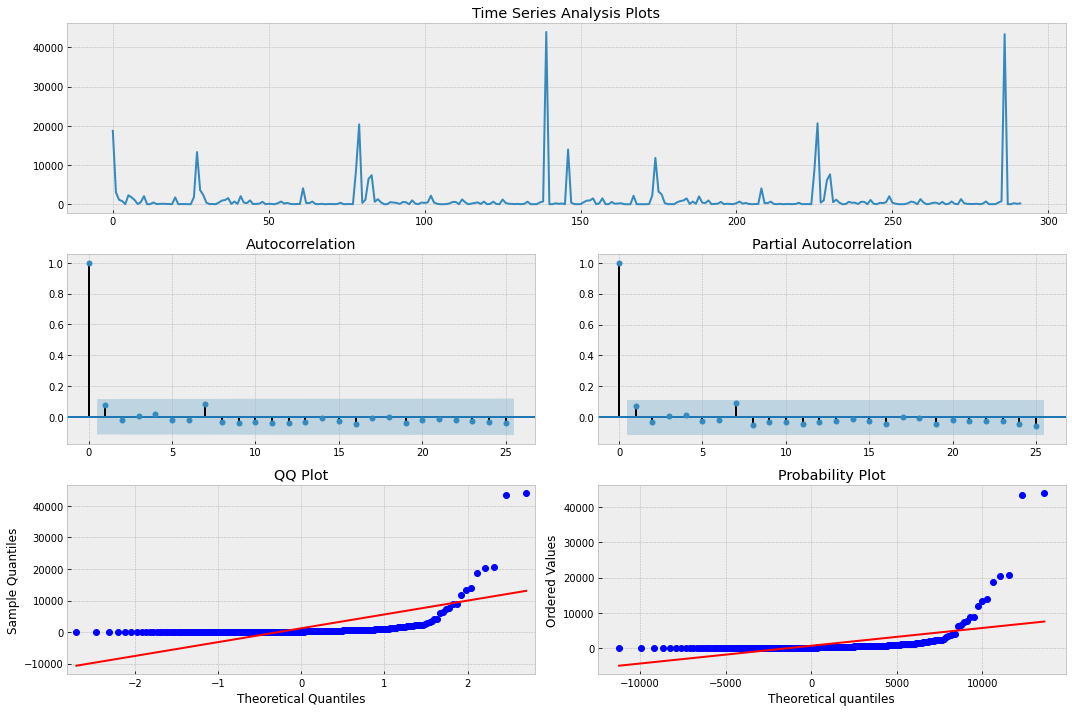

In [45]:
#check for heteroskedasity of the residual
tsplot(model_fit.resid**2)

In [46]:




plt.plot(IndexedDataset['Close_BOM500002_logdiff'])
plt.plot(best_model_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((best_model_ARIMA.fittedvalues.fillna(0)-IndexedDataset['Close_BOM500002_logdiff'].fillna(0)).fillna(0)**2))
print('Plotting AR Model')

KeyError: ignored

**Squared residuals show Autocorrelation**

We will apply GARCH model with p=1 and q=1

In [ ]:
!pip install -q arch

In [ ]:
from arch import arch_model

# Using student T distribution usually provides better fit
am = arch_model(best_model_ARIMA.resid, p=order[0], o=order[1], q=order[2], dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                1452.98
Distribution:      Standardized Student's t   AIC:                          -2889.95
Method:                  Maximum Likelihood   BIC:                          -2853.12
                                              No. Observations:                  738
Date:                      Wed, Jun 24 2020   Df Residuals:                      730
Time:                              02:02:17   Df Model:                            8
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003228. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


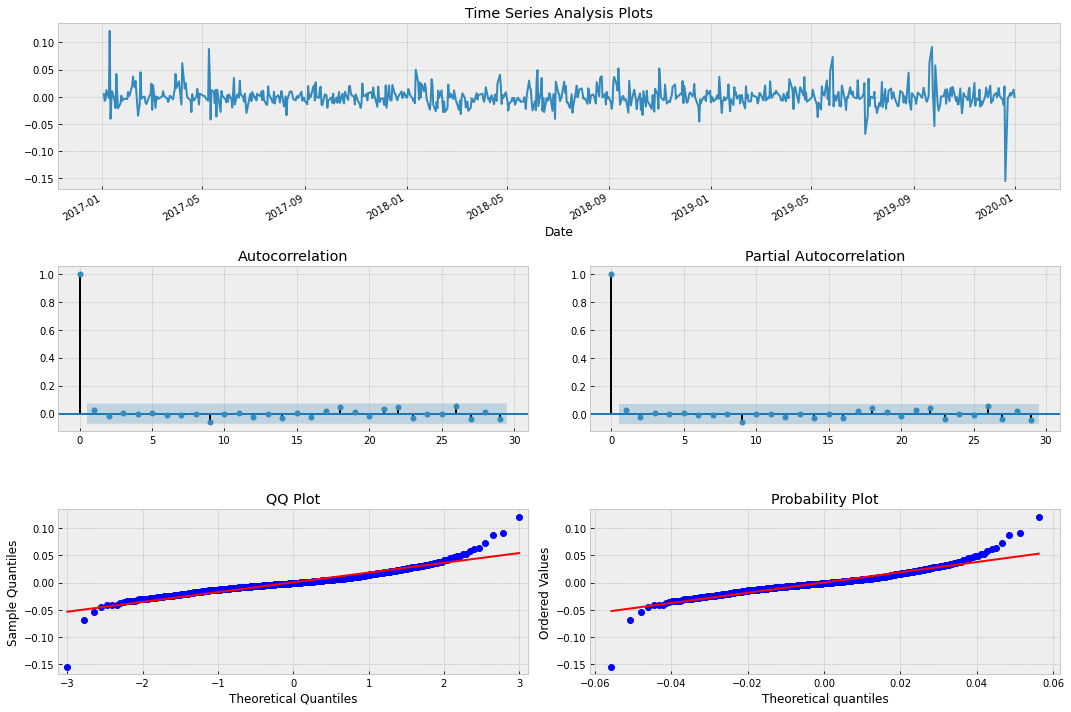

In [ ]:
tsplot(res.resid)

**From above plot there is no Auocorrelaion**

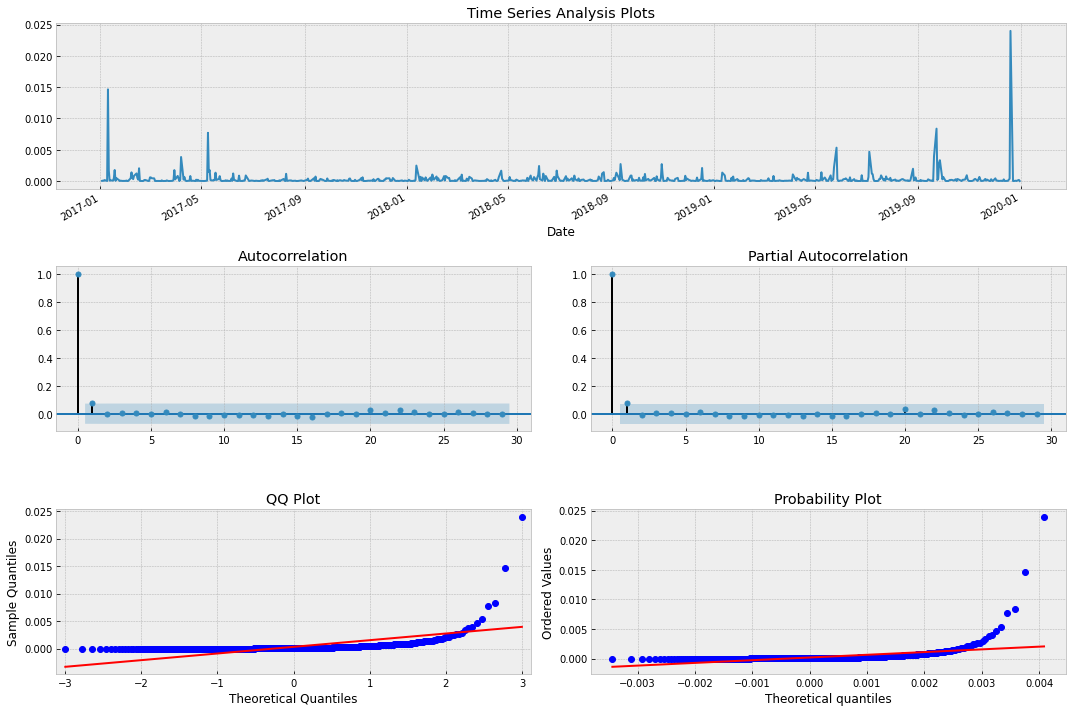

In [ ]:
#check for Autocorrelation for residual squared
tsplot(res.resid**2)

In [ ]:
best_model_ARIMA.forecast()[0]


array([7.16250897])